In [1]:
import os, matplotlib, json, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage , misc, stats
matplotlib.style.use('ggplot')
matplotlib.rc("savefig", dpi=300)
%matplotlib inline

In [2]:
def generatecelllocationarrayGrouping(structureslist,ID,Regionnames,parentid):
    cellmap = pd.DataFrame({'SectionNumber': structureslist[:,0],
                            'StructureID': ID,
                            'Side': structureslist[:,1],
                            'StructureName': Regionnames,
                            'parent_structure_id': parentid,
                            
                            
                           })
    return cellmap

In [3]:
def generatecelllocationarray(structureslist,sectionnumber,Regionnames,parentid,parentname):
    cellmap = pd.DataFrame({'SectionNumber': np.array([sectionnumber] * len(structureslist)),
                            'StructureID': structureslist[:,1],
                            'Side': structureslist[:,2],
                            'StructureName': Regionnames,
                            'parent_structure_id': parentid,
                            
                            
                           })
    return cellmap

In [4]:
def filterAllenMapbySingle(allenmap,conversionkeyword,startkeyword,identifier):
    filtered = allenmap[conversionkeyword].values[np.nonzero(allenmap[[startkeyword]].values==identifier)[0]]
    return filtered

In [5]:
def filterAllenMapby(allenmap,conversionkeyword,startkeyword,identifierIter):
    filtered = [allenmap[conversionkeyword].values[np.nonzero(allenmap[[startkeyword]].values==identifier)[0][0]] for identifier in identifierIter]
    return filtered

def findmodeofobject (objects,ResizedAllen,allenpandamappath ='W:/Allen/'):
    allenmap = pd.read_pickle(allenpandamappath + 'Allen_Lookup.panda')
    AllenRegion=[]
    [AllenRegion.append([obj[1].start,stats.mode(ResizedAllen[obj].flatten())[0][0].astype('int'),-1]) for obj in objects];
    return AllenRegion

    

def enumerateRegions(objects,ResizedAllen,Sectionnumber,allenpandamappath ='W:/Allen/'):
    allenmap = pd.read_pickle(allenpandamappath + 'Allen_Lookup.panda')
    AllenRegion=[]
    [AllenRegion.append([obj[1].start,stats.mode(ResizedAllen[obj].flatten())[0][0].astype('int'),-1]) for obj in objects];
    AllenRegion= np.array(AllenRegion)
    AllenRegion= AllenRegion[AllenRegion[:,1] > 0]
    AllenRegion= AllenRegion[AllenRegion[:,1] != 8]
    AllenRegion= AllenRegion[AllenRegion[:,1] != 688]
    AllenRegion= AllenRegion[AllenRegion[:,1] != 997]
    
    selector_range = np.arange(AllenRegion.shape[0])
    bool_selector =  (AllenRegion[:,0] < ResizedAllen.shape[1]/2) 
    AllenRegion[selector_range[bool_selector ],2]= 0
    AllenRegion[selector_range[np.invert(bool_selector) ],2] = 1
    Regionnames = filterAllenMapby(allenmap,'name','id',AllenRegion[:,1])
    parentid = filterAllenMapby(allenmap,'parent_structure_id','id',AllenRegion[:,1])
    parentname = filterAllenMapby(allenmap,'name','id',parentid)
    grandparentid = filterAllenMapby(allenmap,'parent_structure_id','id',parentid)
    grandparentname = filterAllenMapby(allenmap,'name','id',grandparentid)
    cellmap = generatecelllocationarray(AllenRegion,Sectionnumber,Regionnames,parentid,parentname)
    return cellmap

In [6]:
def Collect_Pandas(directorylist):
    container = pd.DataFrame()
    container = container.append([pd.read_pickle(file) for file in directorylist])
    return container

In [7]:
def mkdirsafe (newpath):
    if not os.path.exists(newpath): os.makedirs(newpath)

In [8]:
def mkexcel( path_to_pandas, animalname):
    os.chdir(path_to_pandas)
    directory = filterdirectory(os.curdir,".panda")

    Brain = Collect_Pandas(directory)
    LateralizedDF = Brain.groupby(['Side'])
    LeftDF = LateralizedDF.get_group(0)
    RightDF = LateralizedDF.get_group(1)


    TotalCountsDF = pd.DataFrame({'Cells':Brain.StructureName.value_counts()})
    LeftCountsDF = pd.DataFrame({'Cells':LeftDF.StructureName.value_counts()})
    RightCountsDF = pd.DataFrame({'Cells':RightDF.StructureName.value_counts()})


    os.chdir('..')
    mkdirsafe('ExcelSheets')
    #Raw
    Brain.to_pickle('ExcelSheets/'+animalname +'_total.compile')
    Brain.to_excel('ExcelSheets/'+animalname +'_RawTotal.xls')
    LeftDF.to_excel ('ExcelSheets/'+animalname +'_RawLeft.xls')
    RightDF.to_excel ('ExcelSheets/'+animalname +'_RawRight.xls')



    #Compiled
    TotalCountsDF.to_excel ('ExcelSheets/'+animalname +'_TotalFreq.xls')
    LeftCountsDF.to_excel ('ExcelSheets/'+animalname +'_LeftFreq.xls')
    RightCountsDF.to_excel ('ExcelSheets/'+animalname +'_RightFreq.xls')
    

In [9]:
def filterdirectory(path,extension):
    directory= [file for file in os.listdir(path) if file.lower().endswith(extension) and file[0] !='.']
    return directory

In [10]:
def mkmpld3figs (path_to_ExcelSheetsfolder,animalname,prefix=''):
    import mpld3
    from mpld3 import plugins
    os.chdir(path_to_ExcelSheetsfolder)
    TotalCountsDF = pd.read_excel(prefix+animalname+'_TotalFreq.xls')
    fig = plt.figure(figsize=(10,5))
    bars = plt.bar(np.arange(TotalCountsDF.size),TotalCountsDF.values)
    for i, bar in enumerate(bars.get_children()):
        tooltip = mpld3.plugins.LineLabelTooltip(bar, label=str(TotalCountsDF.index[i]))
        mpld3.plugins.connect(plt.gcf(), tooltip)
    plt.xlim(0,50)
    plt.title('Cell Detection for : Subject {0}'.format(animalname))
    plt.ylabel('Cell Count')
    plt.xlabel('Region number (Scroll over Bar for Region Name)')

    a = mpld3.fig_to_html(fig)


    Html_file= open("{0}.html".format(prefix+animalname),"w")
    Html_file.write(a)
    Html_file.close()
    plt.savefig('{0}.svg'.format(prefix+animalname))

In [11]:
def fixpandas (pathtoimages, animalname,allenlibpath='W:/Allen/'):
    os.chdir(pathtoimages)
    pandasdir= filterdirectory('panda/','panda')
    for panda in pandasdir:   
        Sectionnumber = int(panda.split('_')[1].split('.')[0])
        iterator = int(panda.split('_')[0])
        Allen = np.load('arrays/'+str(iterator)+'_'+str(Sectionnumber)+'_'+'AllenResized.npz')['arr_0']
        objects = np.load('3d/'+str(iterator)+'_'+str(Sectionnumber)+'.npz')['arr_0']
        objects = [list(objecta) for objecta in objects]
        cellmap =enumerateRegions(objects,Allen,Sectionnumber,allenlibpath)
        cellmap.to_pickle('panda/'+ str(iterator) + '_' +str(Sectionnumber)+'.panda')
        #mkexcel(pathtoimages +'panda', animalname)
        #mkmpld3figs(pathtoimages +'ExcelSheets',animalname)

In [12]:
input_form = """
<div style="border:solid navy; padding:20px;">
<input type="file" id="file_selector" name="files[]"/>
<output id="list"></output>
</div>
"""

javascript = """
<script type="text/Javascript">
  function handleFileSelect(evt) {
    var kernel = IPython.notebook.kernel;
    var files = evt.target.files; // FileList object
    console.log('Executing orig')
    console.log(files)
    // files is a FileList of File objects. List some properties.
    var output = [];
    var f = files[0]
    output.push('<li><strong>', escape(f.name), '</strong> (', f.type || 'n/a', ') - ',
                  f.size, ' bytes, last modified: ',
                  f.lastModifiedDate ? f.lastModifiedDate.toLocaleDateString() : 'n/a',
                  '</_Mli>');
    document.getElementById('list').innerHTML = '<ul>' + output.join('') + '</ul>';
    var command = 'fname = "' + f.name + '"'
    console.log(command)
    kernel.execute(command);
  }

  document.getElementById('file_selector').addEventListener('change', handleFileSelect, false);
</script>
"""

def file_selector():
    from IPython.display import HTML, display
    display(HTML(input_form + javascript))

In [13]:
def fixpandasEasyRun(path_to_images,animalname):
    fixpandas(path_to_images,animalname)
    mkexcel(path_to_images + '\panda', animalname)
    mkmpld3figs(path_to_images + '\ExcelSheets',animalname)
    

    

In [14]:
def mk_Brain_excel_from_panda(path_to_images,Brain, animalname, prefix=''):
    os.chdir(path_to_images)

    LateralizedDF = Brain.groupby(['Side'])
    LeftDF = LateralizedDF.get_group(0)
    RightDF = LateralizedDF.get_group(1)


    TotalCountsDF = pd.DataFrame({'Cells':Brain.StructureName.value_counts()})
    LeftCountsDF = pd.DataFrame({'Cells':LeftDF.StructureName.value_counts()})
    RightCountsDF = pd.DataFrame({'Cells':RightDF.StructureName.value_counts()})


    mkdirsafe('ExcelSheets')
    #Raw
    Brain.to_pickle('ExcelSheets/'+prefix+animalname +'_total.compile')
    Brain.to_excel('ExcelSheets/'+prefix+animalname +'_RawTotal.xls')
    LeftDF.to_excel ('ExcelSheets/'+prefix+animalname +'_RawLeft.xls')
    RightDF.to_excel ('ExcelSheets/'+prefix+animalname +'_RawRight.xls')



    #Compiled
    TotalCountsDF.to_excel ('ExcelSheets/'+prefix+animalname +'_TotalFreq.xls')
    LeftCountsDF.to_excel ('ExcelSheets/'+prefix+animalname +'_LeftFreq.xls')
    RightCountsDF.to_excel ('ExcelSheets/'+prefix+animalname +'_RightFreq.xls')
    

In [15]:
def CollectGroups (path_to_images,allenmappath ='W:/Allen/Allen_Lookup.panda',parenstructurespath='W:/Allen/ParentStructures.xls' ):

    os.chdir(path_to_images)
    arraysdir= filterdirectory('ExcelSheets/','compile')
    animalname = arraysdir[0].split('_')[0]
    allenmap = pd.read_pickle(allenmappath)
    os.chdir(path_to_images + 'ExcelSheets/')
    oldestancestor = pd.read_excel(parenstructurespath)
    brain = pd.read_pickle(arraysdir[0])
    brain = brain.reset_index(drop=True)
    b = brain
    done = pd.DataFrame()

    

    while b.empty !=True:
        currentdone = pd.DataFrame()
        hold =[b[b.StructureID==ID] for ID in oldestancestor.ID.values]
        hold = [x for x in hold if x.empty != True]
        currentdone = currentdone.append([h for h in hold])
        done = done.append([h for h in hold])
        b = b.drop(currentdone.index)
        Regionnames = filterAllenMapby(allenmap,'name','id',b.parent_structure_id.values)
        parentid = filterAllenMapby(allenmap,'parent_structure_id','id',b.parent_structure_id)
        cellmap = generatecelllocationarrayGrouping(b.iloc[:,0:2].values,b.parent_structure_id,Regionnames,parentid)
        cellmap.set_index(b.index)
        b= cellmap    

    return done.sort_index()

In [16]:
def EasyfixAndCollectCompiled (path_to_images,animalname):
    fixpandas(path_to_images,animalname)
    mkexcel(path_to_images + '\panda', animalname)
    mkmpld3figs(path_to_images + '\ExcelSheets',animalname)
    collected = CollectGroups(path_to_images)
    mk_Brain_excel_from_panda(path_to_images,collected,animalname,'collected_')
    mkmpld3figs(path_to_images + '\ExcelSheets',animalname,'collected_')
    

    

C:\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


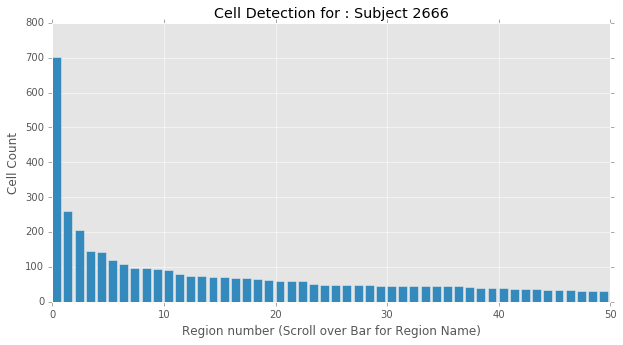

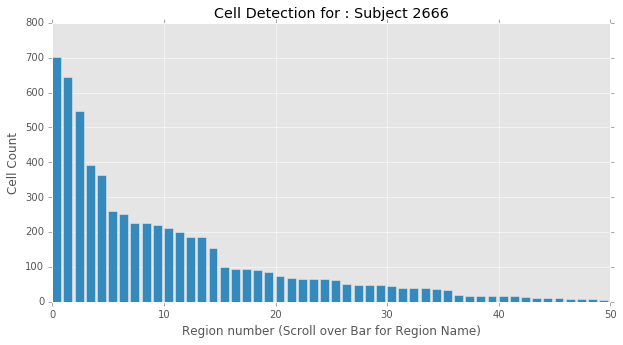

In [17]:
EasyfixAndCollectCompiled('W:/Confirmed Images/D1D2 Chronic Pain/D2/2666_fixed Cuff/','2666') #REPLACE THIS WITH PROPER FILE PATHS AND NAMES

In [18]:
a = CollectGroups('W:/Confirmed Images/D1D2 Chronic Pain/D2/2666_fixed Cuff/') #REPLACE THIS WITH PROPER FILE PATHS AND NAMES

In [ ]:
path_to_images = 'W:/Confirmed Images/D1D2 Chronic Pain/D2/2666_fixed Cuff/' #REPLACE THIS WITH PROPER FILE PATHS AND NAMES

In [ ]:
animalname = '2666' #REPLACE THIS WITH PROPER FILE PATHS AND NAMES
fixpandas('W:/Confirmed Images/D1D2 Chronic Pain/D2/2666_fixed Cuff/',animalname) #REPLACE THIS WITH PROPER FILE PATHS AND NAMES


In [ ]:
mk_Brain_excel_from_panda(path_to_images,a,animalname,'collected_')
mkmpld3figs(path_to_images + '\ExcelSheets',animalname,'collected_')

In [ ]:
path_to_images

In [ ]:
mkexcel(path_to_images + '\panda', animalname)

In [ ]:
mkmpld3figs(path_to_images + '\ExcelSheets',animalname)

In [ ]:
os.chdir('W:/Confirmed Images/D1D2 Chronic Pain/D2/2666_fixed Cuff/')#REPLACE THIS WITH PROPER FILE PATHS AND NAMES
a = os.listdir(os.curdir)
allenmap = pd.read_pickle('W:/Allen/Allen_Lookup.panda')
oldestancestor = pd.read_excel('W:/Lucid/Allen/ParentStructures.xls')
brain = pd.read_pickle('W:/Confirmed Images/D1D2 Chronic Pain/D2/2666_fixed Cuff/ExcelSheets/2666_total.compile')#REPLACE THIS WITH PROPER FILE PATHS AND NAMES
brain = brain.reset_index(drop=True)

Currentuniqueregions = np.unique(brain.StructureID)
parentuniqueregions = np.unique(brain.parent_structure_id)

filterAllenMapby(allenmap,'name','id',parentuniqueregions[0])

parentuniqueregions[0]

oldestancestor.ID.values

filterAllenMapby(brain,'name',)

In [ ]:
hold =[brain[brain.StructureID==ID] for ID in oldestancestor.ID.values]
hold = [x for x in hold if x.empty != True] 
done = pd.DataFrame()
done = done.append([h for h in hold])

In [ ]:
hold[0].index

In [ ]:
b= brain
done = pd.DataFrame()
i=0

while b.empty !=True:
    currentdone = pd.DataFrame()
    hold =[b[b.StructureID==ID] for ID in oldestancestor.ID.values]
    hold = [x for x in hold if x.empty != True]
    currentdone = currentdone.append([h for h in hold])
    done = done.append([h for h in hold])
    b = b.drop(currentdone.index)
    Regionnames = filterAllenMapby(allenmap,'name','id',b.parent_structure_id.values)
    parentid = filterAllenMapby(allenmap,'parent_structure_id','id',b.parent_structure_id)
    cellmap = generatecelllocationarrayGrouping(b.iloc[:,0:2].values,b.parent_structure_id,Regionnames,parentid)
    cellmap.set_index(b.index)
    b= cellmap    
    i = i+1
    print (i)

In [ ]:
 filterAllenMapby(allenmap,'name','id',parentid[300:456])

In [ ]:
done = done.sort_index()

In [ ]:
done

In [ ]:
print(parentid[450:458])
print(nowid[450:458])

In [ ]:
print(b.StructureID.values[237])
print(b.parent_structure_id.values[237])


In [ ]:
brain.ix[552]

In [ ]:
b[b.StructureID==8]

In [ ]:
Regionnames = filterAllenMapby(allenmap,'name','id',b.parent_structure_id.values)
parentid = filterAllenMapby(allenmap,'parent_structure_id','id',b.parent_structure_id.values)
parentname = filterAllenMapby(allenmap,'name','id',parentid)
cellmap = generatecelllocationarrayGrouping(b.iloc[:,0:2].values,b.parent_structure_id,Regionnames,parentid,parentname)
cellmap.set_index(b.index)
b= cellmap

In [ ]:
objects =np.load('C:/Users/dfpena/Desktop/Safe/3d/0_110.npz')['arr_0']

In [ ]:
objectslist = [list(objecta) for objecta in objects]

In [ ]:
resizeallen =np.load('C:/Users/dfpena/Desktop/Safe/arrays/0_110_AllenResized.npz')['arr_0']